# Customer Churn Prediction - Model Development

This notebook implements and evaluates various machine learning models for predicting customer churn.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import pickle
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE

# Set up plotting
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Create directories for saving outputs
os.makedirs('../models', exist_ok=True)
os.makedirs('../docs/plots', exist_ok=True)

## 1. Load the Engineered Data

In [2]:
# Load the engineered data
df_engineered = pd.read_csv('../data/processed/churn_engineered.csv')

# Display basic information
print(f"Dataset shape: {df_engineered.shape}")
print(f"\nColumns: {df_engineered.columns.tolist()}")
print(f"\nSample data:")
df_engineered.head()

Dataset shape: (10000, 42)

Columns: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male', 'AgeGroup', 'IsYoung', 'IsMiddleAged', 'IsSenior', 'IsRetirementAge', 'GermanyXAge', 'GermanyXBalance', 'GermanyXSenior', 'HasZeroBalance', 'BalanceToSalaryRatio', 'HasHighBalance', 'HasMultipleProducts', 'HasManyProducts', 'ProductsXAge', 'ProductsXBalance', 'ProductsXTenure', 'IsNewCustomer', 'IsLongTermCustomer', 'TenureSquared', 'CustomerValue', 'EngagementScore', 'ActiveXTenure', 'ActiveXProducts', 'ActiveXAge', 'InactiveSenior', 'ChurnRiskScore', 'DemographicRiskScore', 'ProductRiskScore']

Sample data:


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,...,TenureSquared,CustomerValue,EngagementScore,ActiveXTenure,ActiveXProducts,ActiveXAge,InactiveSenior,ChurnRiskScore,DemographicRiskScore,ProductRiskScore
0,619.0,42.0,2,0.00,1.0,1,1,101348.88,1,True,...,4,0.00000,0.85,2,1.0,42.0,0,0.10,0.2,0.0
1,608.0,41.0,1,83807.86,1.0,0,1,112542.58,0,False,...,1,83.80786,0.55,1,1.0,41.0,0,0.10,0.2,0.2
2,502.0,42.0,8,159660.80,3.0,1,0,113931.57,1,True,...,64,1277.28640,0.45,0,0.0,0.0,0,0.55,0.2,0.8
3,699.0,39.0,1,0.00,2.0,0,0,93826.63,0,True,...,1,0.00000,0.10,0,0.0,0.0,0,0.35,0.2,0.5
4,850.0,43.0,2,125510.82,1.0,1,1,79084.10,0,False,...,4,251.02164,0.85,2,1.0,43.0,0,0.10,0.2,0.0


## 2. Load Feature Sets

In [3]:
# Load feature sets
with open('../models/feature_sets.json', 'r') as f:
    feature_sets = json.load(f)

# Print feature set sizes
for name, features in feature_sets.items():
    print(f"{name}: {len(features)} features")

all: 41 features
original: 13 features
f_score_top20: 20 features
mi_score_top20: 20 features
common: 16 features
selected_top: 19 features


## 3. Prepare Data for Modeling

In [4]:
# Function to prepare data for a specific feature set
def prepare_data(df, feature_set_name, test_size=0.2, random_state=42, apply_smote=False):
    # Get features for the specified feature set
    features = feature_sets[feature_set_name]
    
    # Prepare features and target
    X = df[features]
    y = df['Exited']
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    # Apply SMOTE to handle class imbalance if requested
    if apply_smote:
        smote = SMOTE(random_state=random_state)
        X_train, y_train = smote.fit_resample(X_train, y_train)
        print(f"After SMOTE - Class distribution: {pd.Series(y_train).value_counts()}")
    
    return X_train, X_test, y_train, y_test

In [5]:
# Check class distribution
print("Class distribution:")
print(df_engineered['Exited'].value_counts())
print(f"Churn rate: {df_engineered['Exited'].mean() * 100:.2f}%")

# Prepare data for modeling using the selected feature set
feature_set_name = 'selected_top'  # We'll use the selected top features
X_train, X_test, y_train, y_test = prepare_data(df_engineered, feature_set_name, apply_smote=True)

Class distribution:
Exited
0    7963
1    2037
Name: count, dtype: int64
Churn rate: 20.37%
After SMOTE - Class distribution: Exited
1    6370
0    6370
Name: count, dtype: int64


## 4. Model Development

### 4.1 Logistic Regression (Baseline)

Logistic Regression Results (with Pipeline):
Accuracy: 0.8345
Precision: 0.5892
Recall: 0.6167
F1 Score: 0.6026
ROC AUC: 0.8326


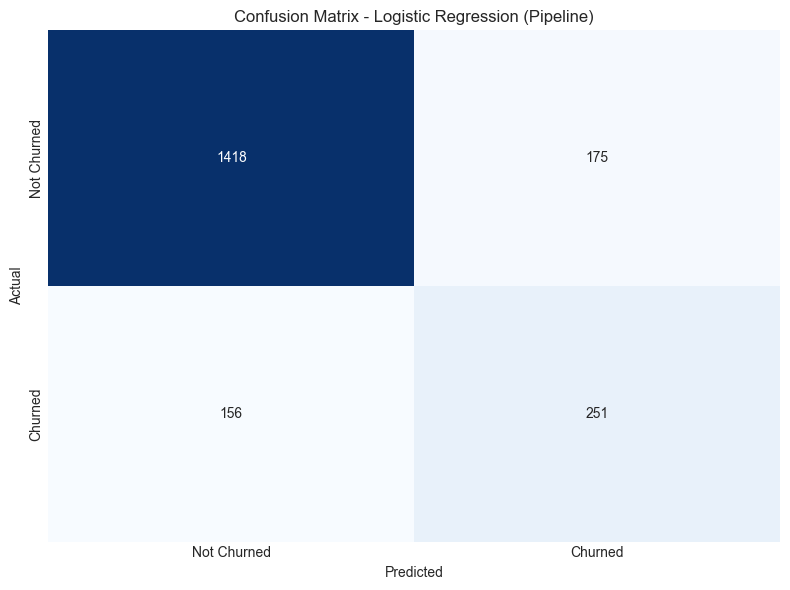


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      1593
           1       0.59      0.62      0.60       407

    accuracy                           0.83      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.84      0.83      0.84      2000

Logistic Regression pipeline saved to ../models/logistic_regression_pipeline.pkl


In [6]:


# Create a pipeline with standardization and logistic regression
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_regression', LogisticRegression(random_state=42, max_iter=2000, class_weight='balanced'))
])

# Train the pipeline
lr_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_pipeline.predict(X_test)
y_prob_lr = lr_pipeline.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Logistic Regression Results (with Pipeline):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_lr):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_lr):.4f}")

# Confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression (Pipeline)')
plt.tight_layout()
plt.savefig('../docs/plots/lr_pipeline_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

# Save the pipeline
with open('../models/logistic_regression_pipeline.pkl', 'wb') as f:
    pickle.dump(lr_pipeline, f)
print("Logistic Regression pipeline saved to ../models/logistic_regression_pipeline.pkl")

### 4.2 Random Forest

Random Forest Results:
Accuracy: 0.8385
Precision: 0.6355
Recall: 0.4840
F1 Score: 0.5495
ROC AUC: 0.8380


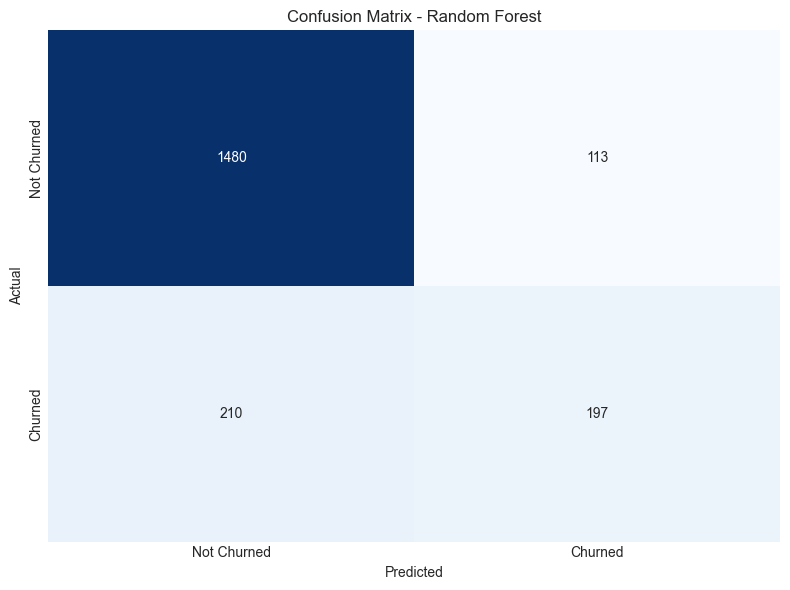


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      1593
           1       0.64      0.48      0.55       407

    accuracy                           0.84      2000
   macro avg       0.76      0.71      0.73      2000
weighted avg       0.83      0.84      0.83      2000



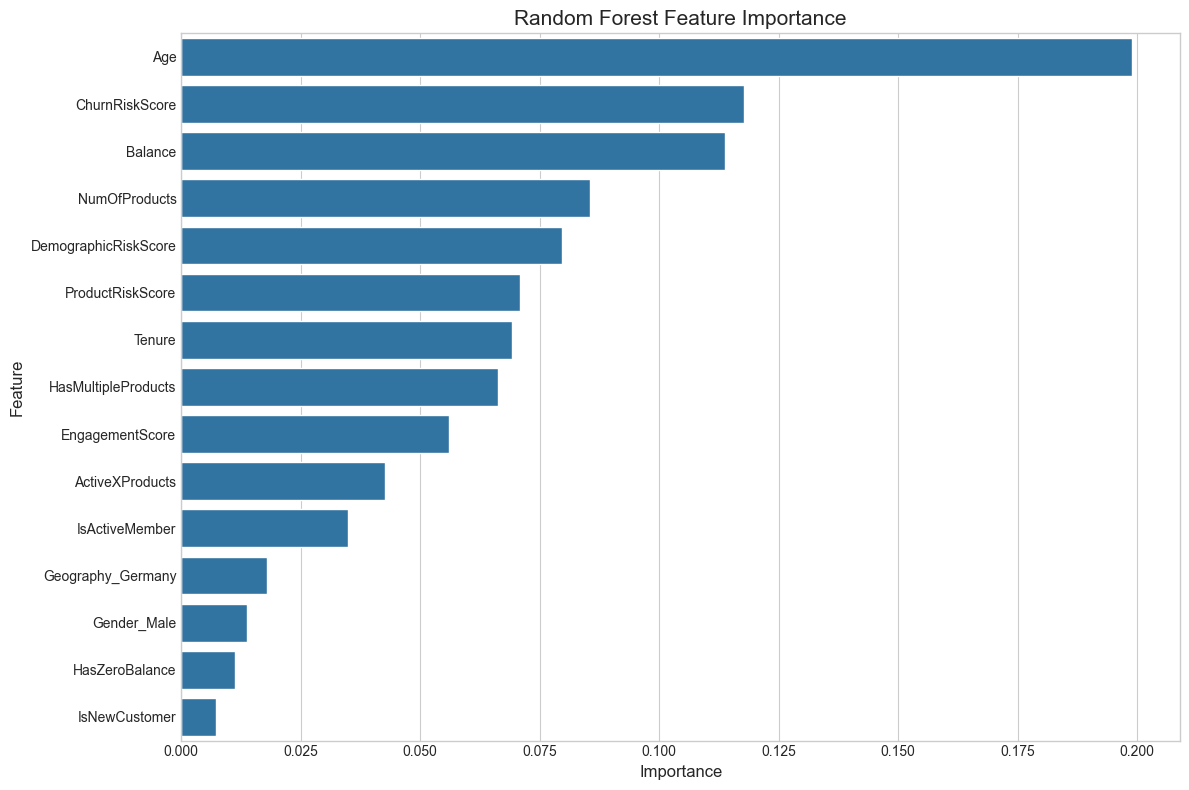

Random Forest model saved to ../models/random_forest.pkl


In [7]:
# Train Random Forest model
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Random Forest Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_rf):.4f}")

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.tight_layout()
plt.savefig('../docs/plots/rf_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Random Forest Feature Importance', fontsize=15)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('../docs/plots/rf_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Save the model
with open('../models/random_forest.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
print("Random Forest model saved to ../models/random_forest.pkl")

### 4.3 XGBoost

XGBoost Results:
Accuracy: 0.8010
Precision: 0.5083
Recall: 0.6732
F1 Score: 0.5793
ROC AUC: 0.8340


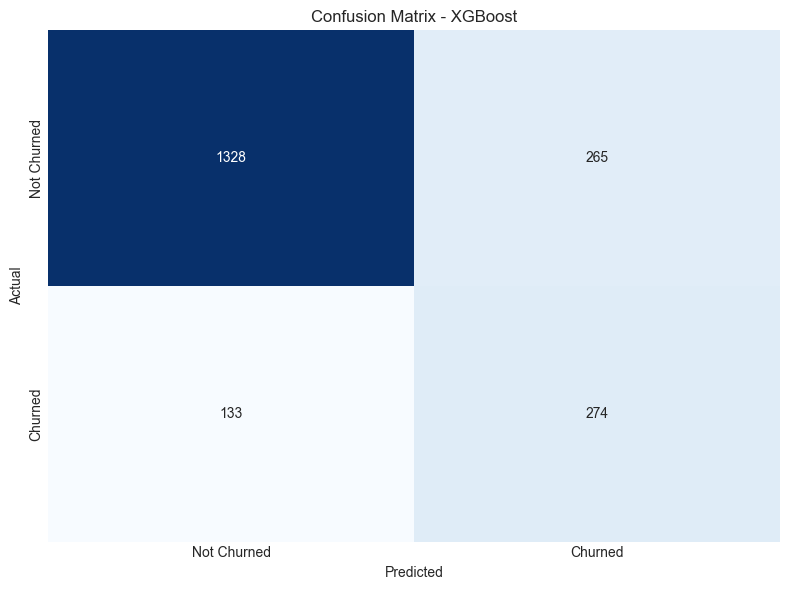


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      1593
           1       0.51      0.67      0.58       407

    accuracy                           0.80      2000
   macro avg       0.71      0.75      0.72      2000
weighted avg       0.83      0.80      0.81      2000



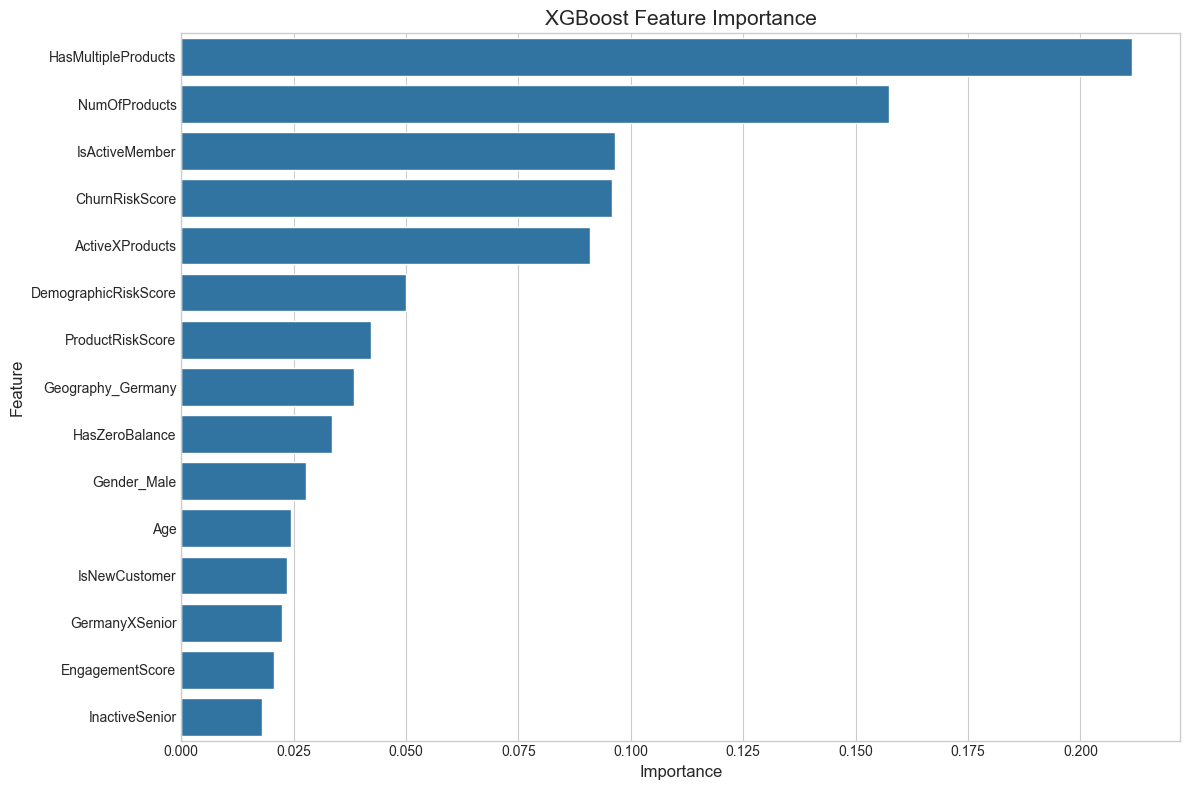

XGBoost model saved to ../models/xgboost.pkl


In [8]:
# Train XGBoost model
xgb_model = XGBClassifier(random_state=42, scale_pos_weight=4)  # scale_pos_weight helps with class imbalance
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("XGBoost Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_xgb):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_xgb):.4f}")

# Confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.tight_layout()
plt.savefig('../docs/plots/xgb_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('XGBoost Feature Importance', fontsize=15)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('../docs/plots/xgb_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Save the model
with open('../models/xgboost.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)
print("XGBoost model saved to ../models/xgboost.pkl")

### 4.4 Support Vector Machine

SVM Results:
Accuracy: 0.4595
Precision: 0.2355
Recall: 0.7371
F1 Score: 0.3569
ROC AUC: 0.6107


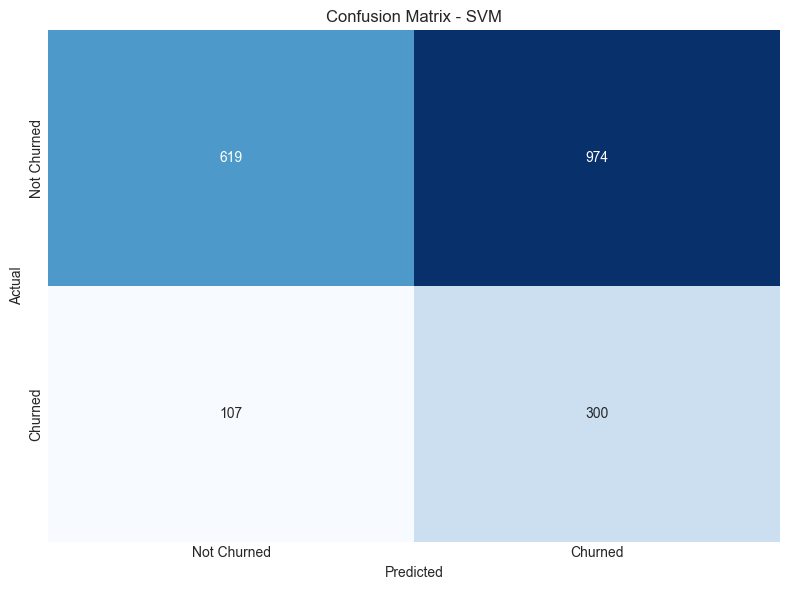


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.39      0.53      1593
           1       0.24      0.74      0.36       407

    accuracy                           0.46      2000
   macro avg       0.54      0.56      0.45      2000
weighted avg       0.73      0.46      0.50      2000

SVM model saved to ../models/svm.pkl


In [9]:
# Train SVM model
svm_model = SVC(random_state=42, probability=True, class_weight='balanced')
svm_model.fit(X_train, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_test)
y_prob_svm = svm_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("SVM Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_svm):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_svm):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_svm):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_svm):.4f}")

# Confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM')
plt.tight_layout()
plt.savefig('../docs/plots/svm_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

# Save the model
with open('../models/svm.pkl', 'wb') as f:
    pickle.dump(svm_model, f)
print("SVM model saved to ../models/svm.pkl")

### 4.5 Neural Network

Neural Network Results:
Accuracy: 0.8000
Precision: 0.5271
Recall: 0.1671
F1 Score: 0.2537
ROC AUC: 0.4829


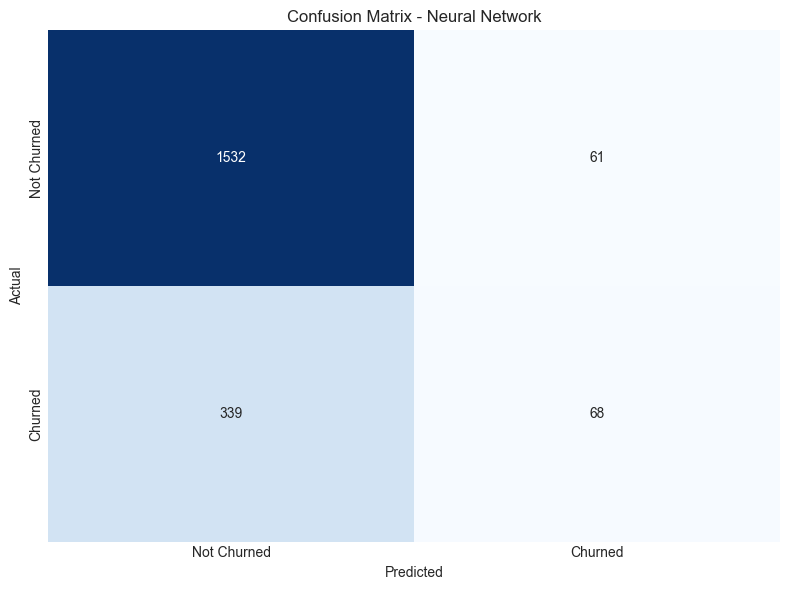


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.88      1593
           1       0.53      0.17      0.25       407

    accuracy                           0.80      2000
   macro avg       0.67      0.56      0.57      2000
weighted avg       0.76      0.80      0.76      2000

Neural Network model saved to ../models/neural_network.pkl


In [10]:
# Train Neural Network model
nn_model = MLPClassifier(random_state=42, max_iter=1000, hidden_layer_sizes=(100, 50), alpha=0.01)
nn_model.fit(X_train, y_train)

# Make predictions
y_pred_nn = nn_model.predict(X_test)
y_prob_nn = nn_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Neural Network Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nn):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_nn):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_nn):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_nn):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_nn):.4f}")

# Confusion matrix
cm_nn = confusion_matrix(y_test, y_pred_nn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Neural Network')
plt.tight_layout()
plt.savefig('../docs/plots/nn_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nn))

# Save the model
with open('../models/neural_network.pkl', 'wb') as f:
    pickle.dump(nn_model, f)
print("Neural Network model saved to ../models/neural_network.pkl")

## 5. Model Comparison

In [11]:
# Collect model results
models = {
    'Logistic Regression': {
        'y_pred': y_pred_lr,
        'y_prob': y_prob_lr,
        'metrics': {
            'accuracy': accuracy_score(y_test, y_pred_lr),
            'precision': precision_score(y_test, y_pred_lr),
            'recall': recall_score(y_test, y_pred_lr),
            'f1': f1_score(y_test, y_pred_lr),
            'roc_auc': roc_auc_score(y_test, y_prob_lr)
        }
    },
    'Random Forest': {
        'y_pred': y_pred_rf,
        'y_prob': y_prob_rf,
        'metrics': {
            'accuracy': accuracy_score(y_test, y_pred_rf),
            'precision': precision_score(y_test, y_pred_rf),
            'recall': recall_score(y_test, y_pred_rf),
            'f1': f1_score(y_test, y_pred_rf),
            'roc_auc': roc_auc_score(y_test, y_prob_rf)
        }
    },
    'XGBoost': {
        'y_pred': y_pred_xgb,
        'y_prob': y_prob_xgb,
        'metrics': {
            'accuracy': accuracy_score(y_test, y_pred_xgb),
            'precision': precision_score(y_test, y_pred_xgb),
            'recall': recall_score(y_test, y_pred_xgb),
            'f1': f1_score(y_test, y_pred_xgb),
            'roc_auc': roc_auc_score(y_test, y_prob_xgb)
        }
    },
    'SVM': {
        'y_pred': y_pred_svm,
        'y_prob': y_prob_svm,
        'metrics': {
            'accuracy': accuracy_score(y_test, y_pred_svm),
            'precision': precision_score(y_test, y_pred_svm),
            'recall': recall_score(y_test, y_pred_svm),
            'f1': f1_score(y_test, y_pred_svm),
            'roc_auc': roc_auc_score(y_test, y_prob_svm)
        }
    },
    'Neural Network': {
        'y_pred': y_pred_nn,
        'y_prob': y_prob_nn,
        'metrics': {
            'accuracy': accuracy_score(y_test, y_pred_nn),
            'precision': precision_score(y_test, y_pred_nn),
            'recall': recall_score(y_test, y_pred_nn),
            'f1': f1_score(y_test, y_pred_nn),
            'roc_auc': roc_auc_score(y_test, y_prob_nn)
        }
    }
}

# Create a DataFrame for model comparison
metrics_df = pd.DataFrame({
    model_name: {metric: value for metric, value in model_info['metrics'].items()}
    for model_name, model_info in models.items()
}).T

# Format metrics for better readability
metrics_df = metrics_df.round(4)

# Display model comparison
print("Model Comparison:")
metrics_df

Model Comparison:


,accuracy,precision,recall,f1,roc_auc
Logistic Regression,0.8345,0.5892,0.6167,0.6026,0.8326
Random Forest,0.8385,0.6355,0.4840,0.5495,0.8380
XGBoost,0.8010,0.5083,0.6732,0.5793,0.8340
SVM,0.4595,0.2355,0.7371,0.3569,0.6107
Neural Network,0.8000,0.5271,0.1671,0.2537,0.4829


/var/folders/7c/2l6cndgj43l70s903bg52_j00000gn/T/ipykernel_98309/1984703736.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df.index, y=metrics_df[metric], palette=colors)
/var/folders/7c/2l6cndgj43l70s903bg52_j00000gn/T/ipykernel_98309/1984703736.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df.index, y=metrics_df[metric], palette=colors)
/var/folders/7c/2l6cndgj43l70s903bg52_j00000gn/T/ipykernel_98309/1984703736.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df.index, y=metrics_df[metric], pa

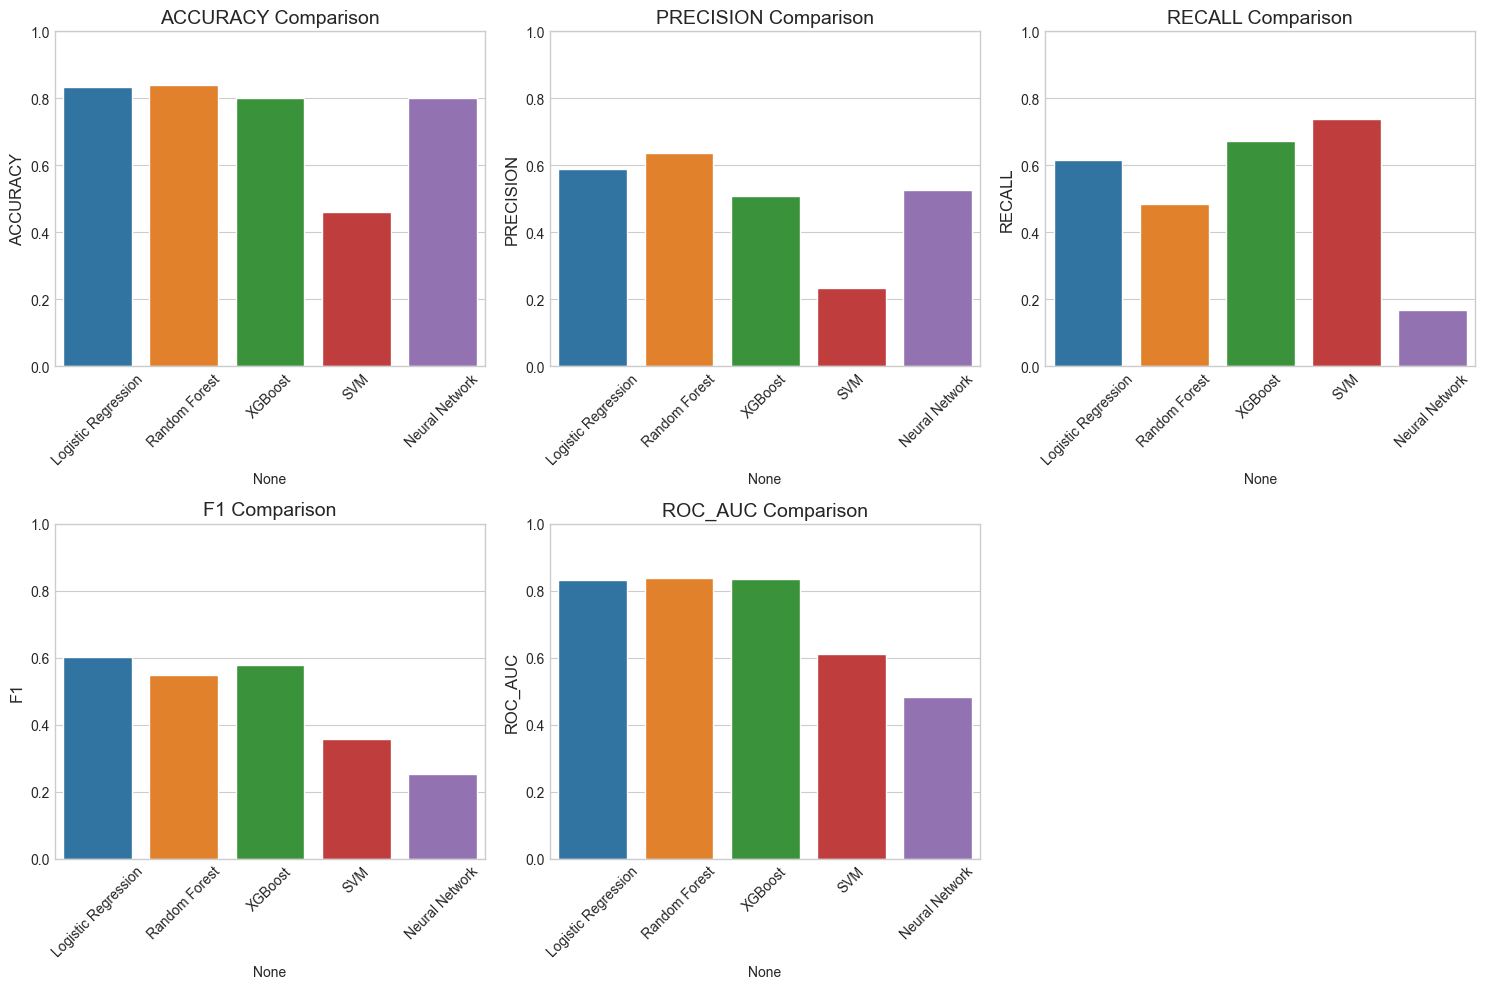

In [12]:
# Visualize model comparison
plt.figure(figsize=(15, 10))

# Plot metrics comparison
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    sns.barplot(x=metrics_df.index, y=metrics_df[metric], palette=colors)
    plt.title(f'{metric.upper()} Comparison', fontsize=14)
    plt.ylabel(metric.upper(), fontsize=12)
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

plt.tight_layout()
plt.savefig('../docs/plots/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

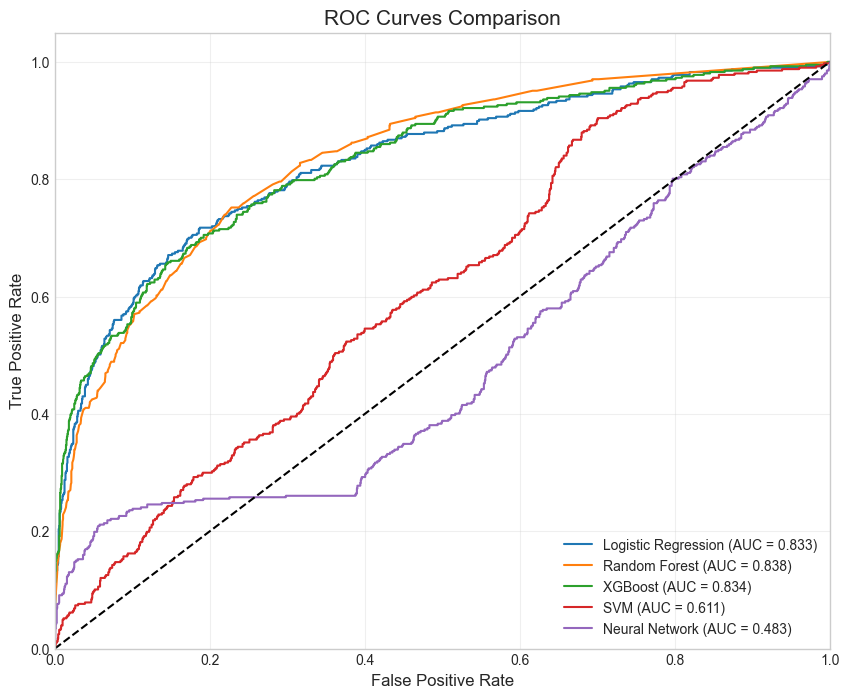

In [13]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

for model_name, model_info in models.items():
    fpr, tpr, _ = roc_curve(y_test, model_info['y_prob'])
    roc_auc = model_info['metrics']['roc_auc']
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=15)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig('../docs/plots/roc_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Select Best Model

Best model: Random Forest with ROC-AUC: 0.8380
Best model information saved to ../models/best_model_info.json


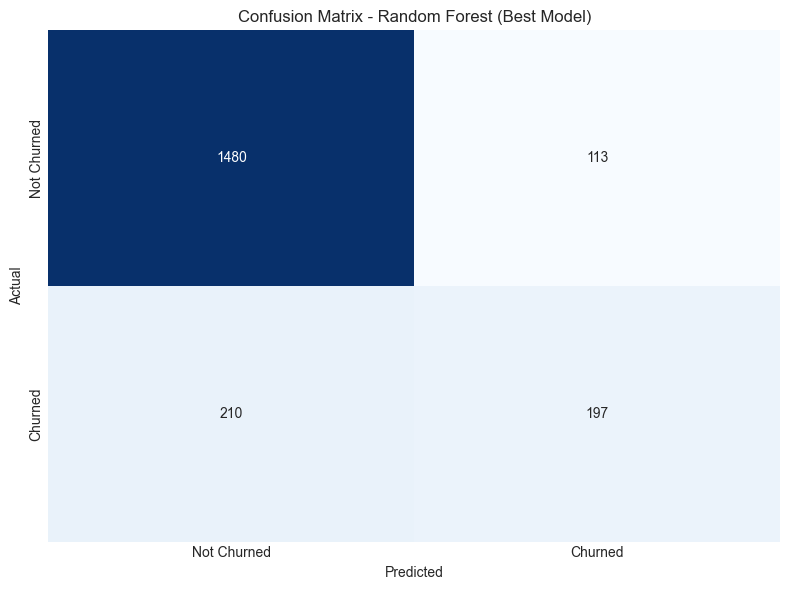

In [14]:
# Identify the best model based on ROC-AUC
best_model_name = metrics_df['roc_auc'].idxmax()
best_model_auc = metrics_df.loc[best_model_name, 'roc_auc']
best_model_info = models[best_model_name]

print(f"Best model: {best_model_name} with ROC-AUC: {best_model_auc:.4f}")

# Save best model information
best_model_info_dict = {
    'model_name': best_model_name,
    'metrics': best_model_info['metrics'],
    'feature_set': feature_set_name
}

with open('../models/best_model_info.json', 'w') as f:
    json.dump(best_model_info_dict, f)

print(f"Best model information saved to ../models/best_model_info.json")

# Visualize confusion matrix for best model
cm_best = confusion_matrix(y_test, best_model_info['y_pred'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_model_name} (Best Model)')
plt.tight_layout()
plt.savefig('../docs/plots/best_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Cost-Benefit Analysis

In [15]:
# Define cost assumptions
cost_losing_customer = 1000  # Cost of losing a customer ($)
cost_retention_program = 100  # Cost of retention program per customer ($)

# Function to calculate cost-benefit
def calculate_cost_benefit(y_true, y_pred, y_prob=None, threshold=0.5):
    if y_prob is not None:
        y_pred = (y_prob >= threshold).astype(int)
    
    # Calculate confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calculate costs
    cost_false_negatives = fn * cost_losing_customer  # Missed churn predictions
    cost_false_positives = fp * cost_retention_program  # Unnecessary retention actions
    cost_true_positives = tp * cost_retention_program  # Necessary retention actions
    
    # Calculate benefits
    benefit_true_positives = tp * cost_losing_customer  # Saved customers
    
    # Calculate net benefit
    total_cost = cost_false_negatives + cost_false_positives + cost_true_positives
    total_benefit = benefit_true_positives
    net_benefit = total_benefit - total_cost
    
    return {
        'total_cost': total_cost,
        'total_benefit': total_benefit,
        'net_benefit': net_benefit,
        'roi': (total_benefit / total_cost if total_cost > 0 else 0) - 1,
        'confusion_matrix': {'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp}
    }

# Calculate cost-benefit for each model
cost_benefit_results = {}
for model_name, model_info in models.items():
    cost_benefit_results[model_name] = calculate_cost_benefit(y_test, model_info['y_pred'])

# Create DataFrame for cost-benefit comparison
cost_benefit_df = pd.DataFrame({
    model_name: {
        'Total Cost ($)': results['total_cost'],
        'Total Benefit ($)': results['total_benefit'],
        'Net Benefit ($)': results['net_benefit'],
        'ROI (%)': results['roi'] * 100
    }
    for model_name, results in cost_benefit_results.items()
}).T

# Format for better readability
cost_benefit_df['Total Cost ($)'] = cost_benefit_df['Total Cost ($)'].map('${:,.0f}'.format)
cost_benefit_df['Total Benefit ($)'] = cost_benefit_df['Total Benefit ($)'].map('${:,.0f}'.format)
cost_benefit_df['Net Benefit ($)'] = cost_benefit_df['Net Benefit ($)'].map('${:,.0f}'.format)
cost_benefit_df['ROI (%)'] = cost_benefit_df['ROI (%)'].map('{:.2f}%'.format)

# Display cost-benefit comparison
print("Cost-Benefit Analysis:")
cost_benefit_df

Cost-Benefit Analysis:


,Total Cost ($),Total Benefit ($),Net Benefit ($),ROI (%)
Logistic Regression,"$198,600","$251,000","$52,400",26.38%
Random Forest,"$241,000","$197,000","$-44,000",-18.26%
XGBoost,"$186,900","$274,000","$87,100",46.60%
SVM,"$234,400","$300,000","$65,600",27.99%
Neural Network,"$351,900","$68,000","$-283,900",-80.68%


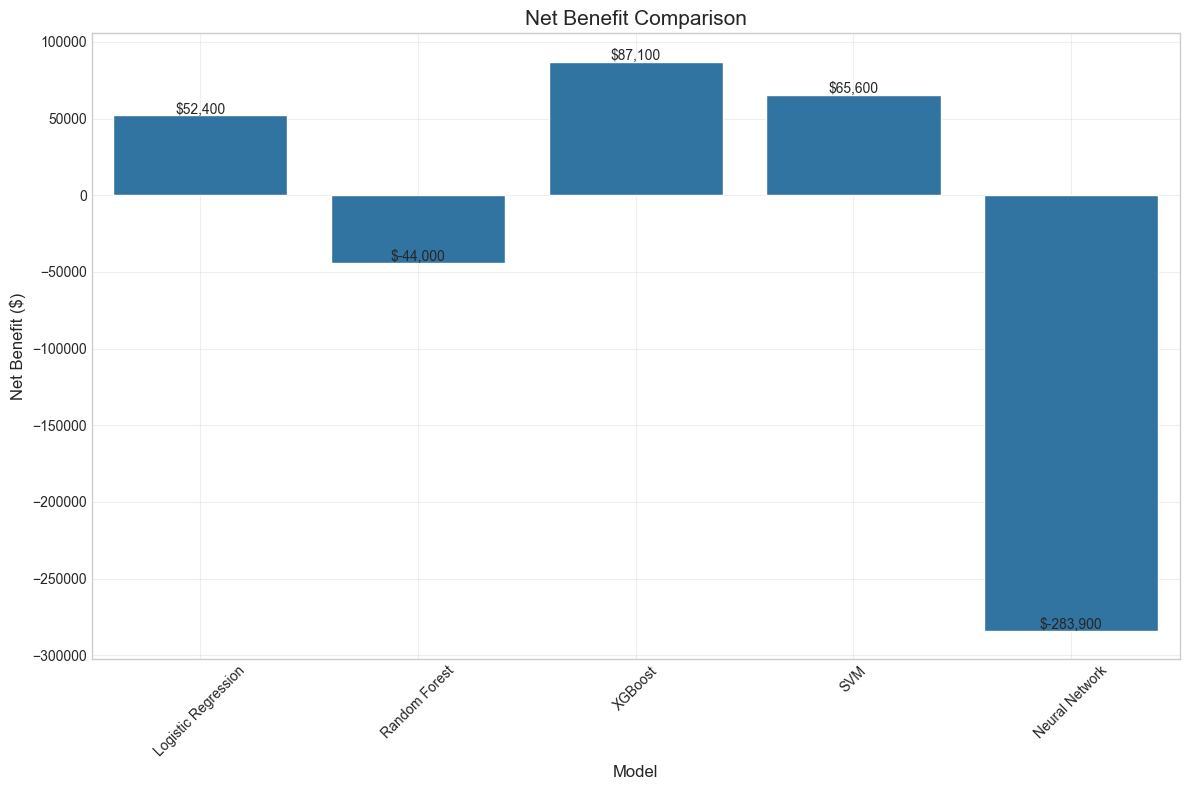

In [16]:
# Visualize cost-benefit comparison
plt.figure(figsize=(12, 8))

# Extract numeric values for plotting
net_benefits = [results['net_benefit'] for results in cost_benefit_results.values()]
model_names = list(cost_benefit_results.keys())

# Create bar chart
sns.barplot(x=model_names, y=net_benefits)
plt.title('Net Benefit Comparison', fontsize=15)
plt.ylabel('Net Benefit ($)', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for i, v in enumerate(net_benefits):
    plt.text(i, v + 1000, f'${v:,.0f}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('../docs/plots/cost_benefit_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Threshold Analysis

In [17]:
# Analyze different probability thresholds for the best model
thresholds = np.arange(0.1, 1.0, 0.05)
threshold_results = []

for threshold in thresholds:
    # Get predictions using the threshold
    y_pred_threshold = (best_model_info['y_prob'] >= threshold).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_threshold)
    precision = precision_score(y_test, y_pred_threshold)
    recall = recall_score(y_test, y_pred_threshold)
    f1 = f1_score(y_test, y_pred_threshold)
    
    # Calculate cost-benefit
    cost_benefit = calculate_cost_benefit(y_test, None, best_model_info['y_prob'], threshold)
    
    threshold_results.append({
        'threshold': threshold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'net_benefit': cost_benefit['net_benefit']
    })

# Create DataFrame for threshold analysis
threshold_df = pd.DataFrame(threshold_results)

# Display threshold analysis
print("Threshold Analysis:")
threshold_df.round(4)

Threshold Analysis:


,threshold,accuracy,precision,recall,f1,net_benefit
0,0.10,0.6805,0.3742,0.8477,0.5192,190800
1,0.15,0.7335,0.4182,0.7912,0.5472,160000
2,0.20,0.7675,0.4567,0.7518,0.5682,138000
3,0.25,0.7885,0.4862,0.6929,0.5714,99000
4,0.30,0.8025,0.5117,0.6437,0.5702,65800
5,0.35,0.8145,0.5400,0.5971,0.5671,34000
6,0.40,0.8295,0.5851,0.5577,0.5711,8200
7,0.45,0.8345,0.6111,0.5135,0.5581,-23200
8,0.50,0.8385,0.6355,0.4840,0.5495,-44000
9,0.55,0.8415,0.6679,0.4398,0.5304,-75800


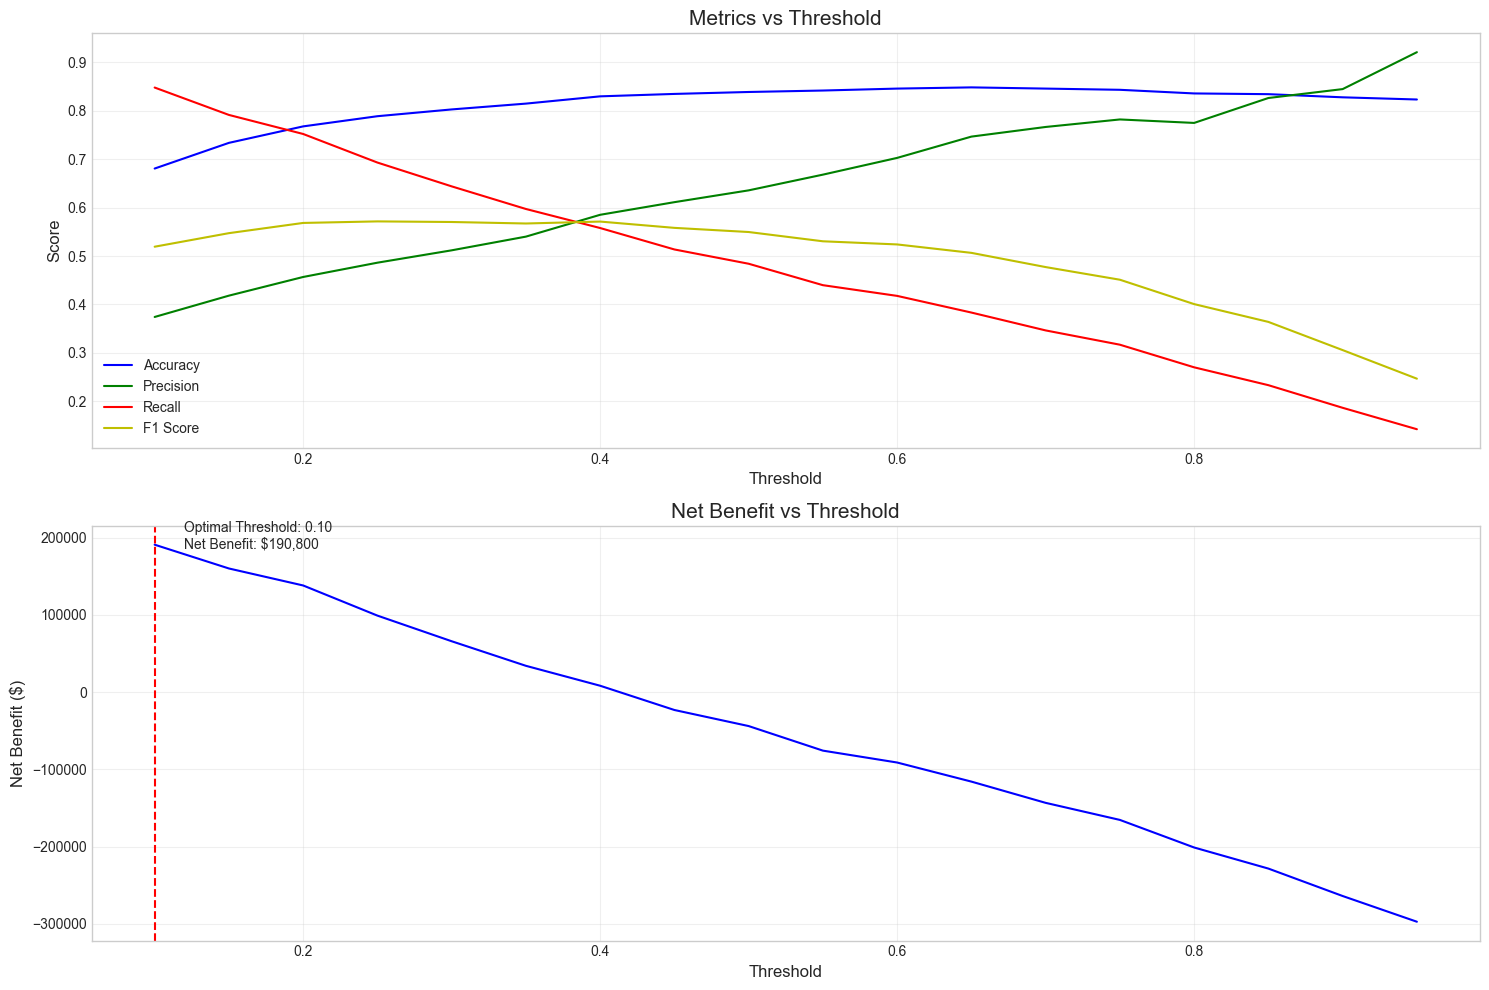

Optimal threshold: 0.10 with net benefit: $190,800


In [18]:
# Visualize threshold analysis
plt.figure(figsize=(15, 10))

# Plot metrics vs threshold
plt.subplot(2, 1, 1)
plt.plot(threshold_df['threshold'], threshold_df['accuracy'], 'b-', label='Accuracy')
plt.plot(threshold_df['threshold'], threshold_df['precision'], 'g-', label='Precision')
plt.plot(threshold_df['threshold'], threshold_df['recall'], 'r-', label='Recall')
plt.plot(threshold_df['threshold'], threshold_df['f1'], 'y-', label='F1 Score')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Metrics vs Threshold', fontsize=15)
plt.grid(True, alpha=0.3)
plt.legend()

# Plot net benefit vs threshold
plt.subplot(2, 1, 2)
plt.plot(threshold_df['threshold'], threshold_df['net_benefit'], 'b-')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Net Benefit ($)', fontsize=12)
plt.title('Net Benefit vs Threshold', fontsize=15)
plt.grid(True, alpha=0.3)

# Find optimal threshold based on net benefit
optimal_threshold_idx = threshold_df['net_benefit'].idxmax()
optimal_threshold = threshold_df.loc[optimal_threshold_idx, 'threshold']
optimal_net_benefit = threshold_df.loc[optimal_threshold_idx, 'net_benefit']

plt.axvline(x=optimal_threshold, color='r', linestyle='--')
plt.text(optimal_threshold + 0.02, optimal_net_benefit - 5000, 
         f'Optimal Threshold: {optimal_threshold:.2f}\nNet Benefit: ${optimal_net_benefit:,.0f}',
         fontsize=10)

plt.tight_layout()
plt.savefig('../docs/plots/threshold_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Optimal threshold: {optimal_threshold:.2f} with net benefit: ${optimal_net_benefit:,.0f}")

## 9. Save Results

In [19]:
# Save model comparison results
metrics_df.to_csv('../models/model_comparison.csv')
print("Model comparison results saved to ../models/model_comparison.csv")

# Save cost-benefit analysis results
pd.DataFrame(cost_benefit_results).to_json('../models/cost_benefit_results.json')
print("Cost-benefit analysis results saved to ../models/cost_benefit_results.json")

# Save threshold analysis results
threshold_df.to_csv('../models/threshold_analysis.csv')
print("Threshold analysis results saved to ../models/threshold_analysis.csv")

# Save optimal threshold
optimal_threshold_info = {
    'optimal_threshold': float(optimal_threshold),
    'metrics_at_optimal_threshold': {
        'accuracy': float(threshold_df.loc[optimal_threshold_idx, 'accuracy']),
        'precision': float(threshold_df.loc[optimal_threshold_idx, 'precision']),
        'recall': float(threshold_df.loc[optimal_threshold_idx, 'recall']),
        'f1': float(threshold_df.loc[optimal_threshold_idx, 'f1']),
        'net_benefit': float(optimal_net_benefit)
    }
}

with open('../models/optimal_threshold.json', 'w') as f:
    json.dump(optimal_threshold_info, f)
print("Optimal threshold information saved to ../models/optimal_threshold.json")

Model comparison results saved to ../models/model_comparison.csv
Cost-benefit analysis results saved to ../models/cost_benefit_results.json
Threshold analysis results saved to ../models/threshold_analysis.csv
Optimal threshold information saved to ../models/optimal_threshold.json


## 10. Conclusion

In [20]:
# Print final summary
print("\n=== Customer Churn Prediction Model Development Summary ===")
print(f"Best model: {best_model_name}")
print(f"ROC-AUC: {best_model_auc:.4f}")
print(f"Optimal threshold: {optimal_threshold:.2f}")
print(f"Net benefit at optimal threshold: ${optimal_net_benefit:,.0f}")
print("\nNext steps:")
print("1. Deploy the model in production")
print("2. Monitor model performance")
print("3. Update the model periodically with new data")
print("4. Implement targeted retention strategies based on model predictions")


=== Customer Churn Prediction Model Development Summary ===
Best model: Random Forest
ROC-AUC: 0.8380
Optimal threshold: 0.10
Net benefit at optimal threshold: $190,800

Next steps:
1. Deploy the model in production
2. Monitor model performance
3. Update the model periodically with new data
4. Implement targeted retention strategies based on model predictions
